# Different Dataset Benchmarks

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

import grid_distillation_lib_demo as gd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from PIL import Image

In [2]:
# print cuda devices
print("CUDA devices: ", torch.cuda.device_count())
print("CUDA device name: ", torch.cuda.get_device_name(0))

# select device and print info
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(0)

CUDA devices:  1
CUDA device name:  NVIDIA GeForce GTX 1650 Ti


_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650 Ti', major=7, minor=5, total_memory=4095MB, multi_processor_count=16)

# Demo - Digits

In [3]:

# Load the dataset
digits = load_digits()
X = digits.images
y = digits.target

# Normalize the images
X = X / 255.0

# Reshape the images to (n_samples, 1, 8, 8)
X = X.reshape(-1, 1, 8, 8)

# Convert labels to torch tensors
y = torch.tensor(y, dtype=torch.long)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train and evaluate the original model
train(model, train_loader, criterion, optimizer, epochs=10)
original_accuracy = evaluate(model, test_loader)
print(f'Original Model Accuracy: {original_accuracy}%')


Epoch [1/10], Loss: 2.3040608353084986
Epoch [2/10], Loss: 2.301523044374254
Epoch [3/10], Loss: 2.2905825985802544
Epoch [4/10], Loss: 2.2040018611484102
Epoch [5/10], Loss: 1.7971376578013103
Epoch [6/10], Loss: 1.2177138672934638
Epoch [7/10], Loss: 0.8748265014754402
Epoch [8/10], Loss: 0.7334274152914683
Epoch [9/10], Loss: 0.6453275614314609
Epoch [10/10], Loss: 0.5826464255650838
Original Model Accuracy: 84.44444444444444%


## Grid

Epoch [1/10], Loss: 2.2976488873765275
Epoch [2/10], Loss: 2.293419651083044
Epoch [3/10], Loss: 2.2888335021766455
Epoch [4/10], Loss: 2.2836576345804573
Epoch [5/10], Loss: 2.2755332250852844
Epoch [6/10], Loss: 2.2468390786969983
Epoch [7/10], Loss: 2.1448359618315824
Epoch [8/10], Loss: 1.7991012850323238
Epoch [9/10], Loss: 1.330739266163594
Epoch [10/10], Loss: 1.0031772723069061
Epoch [1/10], Loss: 2.2995576278583423
Epoch [2/10], Loss: 2.290226581934336
Epoch [3/10], Loss: 2.288132300248017
Epoch [4/10], Loss: 2.282161809302665
Epoch [5/10], Loss: 2.262051298811629
Epoch [6/10], Loss: 2.1997409382381954
Epoch [7/10], Loss: 2.0076274710732536
Epoch [8/10], Loss: 1.6776478580526404
Epoch [9/10], Loss: 1.3514549667770799
Epoch [10/10], Loss: 1.0653400131174036
Epoch [1/10], Loss: 2.294901229239799
Epoch [2/10], Loss: 2.2911122231870085
Epoch [3/10], Loss: 2.290242304673066
Epoch [4/10], Loss: 2.288105281623634
Epoch [5/10], Loss: 2.282951123005635
Epoch [6/10], Loss: 2.27709949338

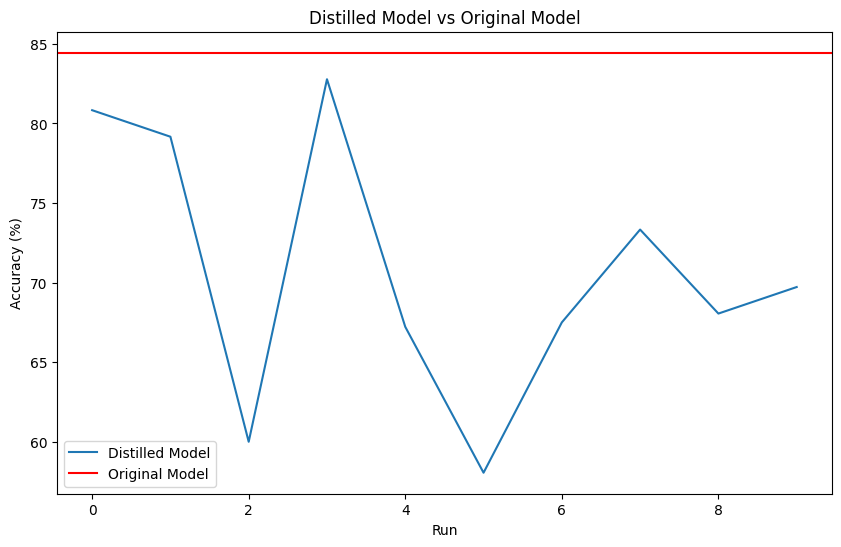

Average Distilled Model Accuracy: 70.66666666666667%
Original Model Accuracy: 84.44444444444444%


In [4]:

n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.GridImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=90)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')

## Paralelogram

Epoch [1/10], Loss: 2.296292949367214
Epoch [2/10], Loss: 2.29067181896519
Epoch [3/10], Loss: 2.286412335730888
Epoch [4/10], Loss: 2.2837612242312044
Epoch [5/10], Loss: 2.2743148223773852
Epoch [6/10], Loss: 2.23684633100355
Epoch [7/10], Loss: 2.1072611518808313
Epoch [8/10], Loss: 1.8913523570911304
Epoch [9/10], Loss: 1.7117367177396208
Epoch [10/10], Loss: 1.5712703917477582
Epoch [1/10], Loss: 2.306137838879147
Epoch [2/10], Loss: 2.294168807364799
Epoch [3/10], Loss: 2.2895350134050525
Epoch [4/10], Loss: 2.2835409061328784
Epoch [5/10], Loss: 2.2771212281407536
Epoch [6/10], Loss: 2.2497889222325504
Epoch [7/10], Loss: 2.1621882399997197
Epoch [8/10], Loss: 1.9103221732216913
Epoch [9/10], Loss: 1.4869081071905188
Epoch [10/10], Loss: 1.1428377644435779
Epoch [1/10], Loss: 2.298321201994612
Epoch [2/10], Loss: 2.2923732899330758
Epoch [3/10], Loss: 2.2905222789661304
Epoch [4/10], Loss: 2.2889645486264616
Epoch [5/10], Loss: 2.285476916545146
Epoch [6/10], Loss: 2.28224166019

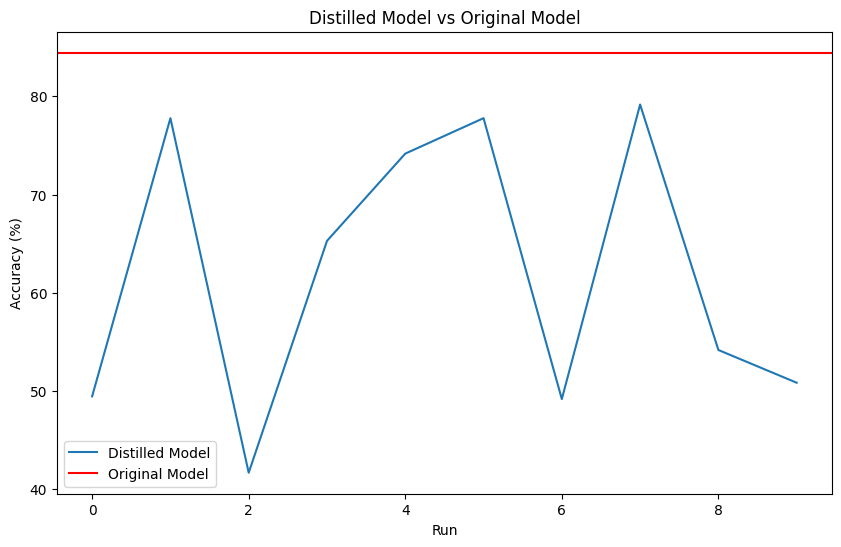

Average Distilled Model Accuracy: 61.94444444444444%
Original Model Accuracy: 84.44444444444444%


In [5]:

n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.ParallelogramImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=90)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Triangular

Epoch [1/10], Loss: 2.2991380562653414
Epoch [2/10], Loss: 2.290404693500416
Epoch [3/10], Loss: 2.2907004356384277
Epoch [4/10], Loss: 2.287101481411908
Epoch [5/10], Loss: 2.283759001139048
Epoch [6/10], Loss: 2.2769131209399247
Epoch [7/10], Loss: 2.246875808045671
Epoch [8/10], Loss: 2.1541523933410645
Epoch [9/10], Loss: 1.900098671784272
Epoch [10/10], Loss: 1.530766570890272
Epoch [1/10], Loss: 2.2987333375054435
Epoch [2/10], Loss: 2.2898250914908744
Epoch [3/10], Loss: 2.2883271977708146
Epoch [4/10], Loss: 2.281622158514487
Epoch [5/10], Loss: 2.2696856356955863
Epoch [6/10], Loss: 2.2217680699116475
Epoch [7/10], Loss: 2.0661842823028564
Epoch [8/10], Loss: 1.6566506269815806
Epoch [9/10], Loss: 1.1765933568413194
Epoch [10/10], Loss: 0.8641916432896176
Epoch [1/10], Loss: 2.297115190609081
Epoch [2/10], Loss: 2.290617781716424
Epoch [3/10], Loss: 2.2886518852130786
Epoch [4/10], Loss: 2.2859376958898596
Epoch [5/10], Loss: 2.2800694285212337
Epoch [6/10], Loss: 2.2699551582

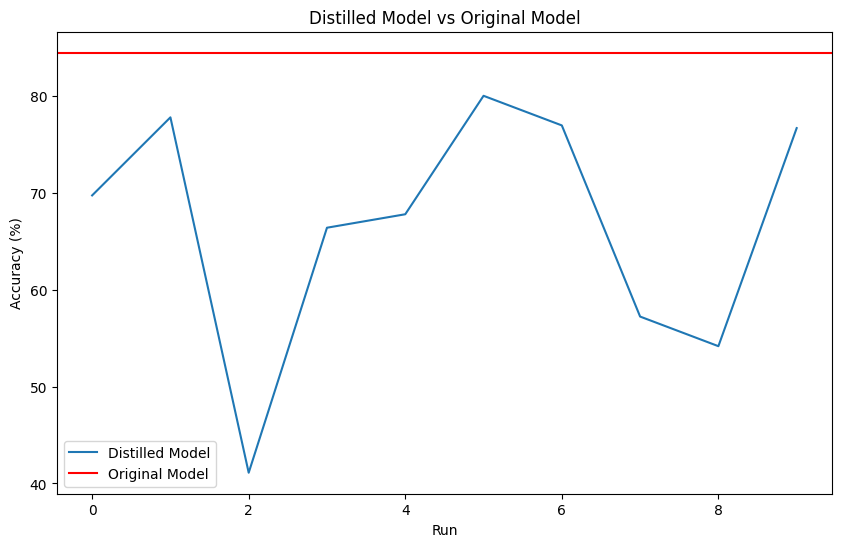

Average Distilled Model Accuracy: 66.77777777777777%
Original Model Accuracy: 84.44444444444444%


In [6]:

n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.TriangularImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=90)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Brick

Epoch [1/10], Loss: 2.2995286954415812
Epoch [2/10], Loss: 2.289677703702772
Epoch [3/10], Loss: 2.2832439396832442
Epoch [4/10], Loss: 2.271658130594202
Epoch [5/10], Loss: 2.2215326992241113
Epoch [6/10], Loss: 2.1362339934787236
Epoch [7/10], Loss: 1.9923749034469191
Epoch [8/10], Loss: 1.756393864348128
Epoch [9/10], Loss: 1.5763032146402307
Epoch [10/10], Loss: 1.371294322851542
Epoch [1/10], Loss: 2.2991727558342188
Epoch [2/10], Loss: 2.290728826780577
Epoch [3/10], Loss: 2.2829592614560514
Epoch [4/10], Loss: 2.2677561850161165
Epoch [5/10], Loss: 2.201006708918391
Epoch [6/10], Loss: 1.995420594473143
Epoch [7/10], Loss: 1.6630352542207048
Epoch [8/10], Loss: 1.2997080780364372
Epoch [9/10], Loss: 1.0360713166159552
Epoch [10/10], Loss: 0.8587691058983674
Epoch [1/10], Loss: 2.294412999539762
Epoch [2/10], Loss: 2.288038679071375
Epoch [3/10], Loss: 2.2767470398464718
Epoch [4/10], Loss: 2.2298469736769393
Epoch [5/10], Loss: 2.065238907530501
Epoch [6/10], Loss: 1.83008005167

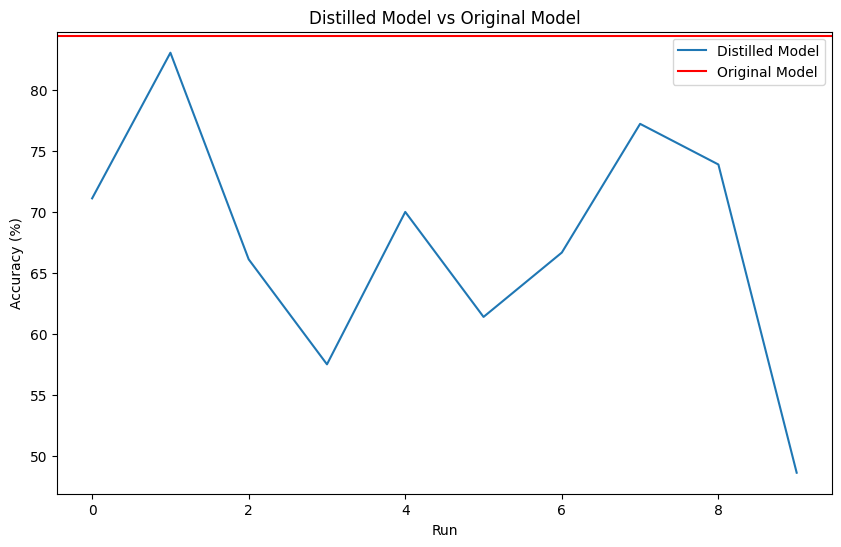

Average Distilled Model Accuracy: 67.55555555555557%
Original Model Accuracy: 84.44444444444444%


In [7]:

n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.BrickImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=90)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')

# Demo - Flowers

In [8]:
# Define the list of flowers and data directory
flowers = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
data_dir = 'C:\\Users\\Hp\\summer_projects\\datasets\\flower_images'

# Load the dataset
dataset = []
for i, flower in enumerate(flowers):
    print(f'Processing {flower} images...')
    flower_dir = os.path.join(data_dir, flower)
    for file in os.listdir(flower_dir):
        image_path = os.path.join(flower_dir, file)
        image = Image.open(image_path)
        image = image.resize((128, 128))  # Resize images to (128, 128)
        dataset.append((np.array(image), i))

# Shuffle the dataset
np.random.shuffle(dataset)

# Split the dataset into images and labels
X = np.array([x[0] for x in dataset], dtype=np.float32) / 255.0
y = np.array([x[1] for x in dataset], dtype=np.int64)

# Convert images to torch tensors
X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)  # Reshape to (N, C, H, W)
y = torch.tensor(y, dtype=torch.long)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training function
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}')

# Define evaluation function
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Train the model
train(model, train_loader, criterion, optimizer, epochs=10)

# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Original Model Accuracy: {accuracy}%')
# 7m 34.7s - Original Model Accuracy: 85.9%

Processing Lilly images...
Processing Lotus images...
Processing Orchid images...
Processing Sunflower images...
Processing Tulip images...
Epoch 1/10, Loss: 1.3492595224380493
Epoch 2/10, Loss: 1.0863560848236085
Epoch 3/10, Loss: 0.9331591420173645
Epoch 4/10, Loss: 0.7982539350986481
Epoch 5/10, Loss: 0.6656167004108429
Epoch 6/10, Loss: 0.496019788980484
Epoch 7/10, Loss: 0.35509597969055173
Epoch 8/10, Loss: 0.2295491020977497
Epoch 9/10, Loss: 0.12678360509872436
Epoch 10/10, Loss: 0.08980883030593395
Original Model Accuracy: 83.9%


## Grid Distillation

C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.403757988859754
Epoch 2/10, Loss: 1.0867563245493337
Epoch 3/10, Loss: 0.870417611314616
Epoch 4/10, Loss: 0.5718707341119784
Epoch 5/10, Loss: 0.3132838683390836
Epoch 6/10, Loss: 0.1482462984501222
Epoch 7/10, Loss: 0.09846897632601338
Epoch 8/10, Loss: 0.06415147712847236
Epoch 9/10, Loss: 0.05046973150189316
Epoch 10/10, Loss: 0.03877739033046597


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3498298017256851
Epoch 2/10, Loss: 1.0148804761947843
Epoch 3/10, Loss: 0.7611234614608484
Epoch 4/10, Loss: 0.5002321551699157
Epoch 5/10, Loss: 0.31213876605033875
Epoch 6/10, Loss: 0.16884767062483577
Epoch 7/10, Loss: 0.09672127865733357
Epoch 8/10, Loss: 0.05265422115837215
Epoch 9/10, Loss: 0.04333834160213282
Epoch 10/10, Loss: 0.02929483303894212


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.403020968130969
Epoch 2/10, Loss: 1.0312676161801049
Epoch 3/10, Loss: 0.789677789451879
Epoch 4/10, Loss: 0.5161596040386672
Epoch 5/10, Loss: 0.3242165778481632
Epoch 6/10, Loss: 0.16151274111839609
Epoch 7/10, Loss: 0.09089528660742788
Epoch 8/10, Loss: 0.0770304560524608
Epoch 9/10, Loss: 0.03807764581443075
Epoch 10/10, Loss: 0.03395525138577395


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4970164703666617
Epoch 2/10, Loss: 1.1844420340083062
Epoch 3/10, Loss: 0.9311934124439134
Epoch 4/10, Loss: 0.6096042834837502
Epoch 5/10, Loss: 0.34269251612895124
Epoch 6/10, Loss: 0.17953429603521978
Epoch 7/10, Loss: 0.09343173676982112
Epoch 8/10, Loss: 0.053475003240954715
Epoch 9/10, Loss: 0.039756554398907844
Epoch 10/10, Loss: 0.032034235384845


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3397523405355052
Epoch 2/10, Loss: 1.025476048298932
Epoch 3/10, Loss: 0.8071055477912273
Epoch 4/10, Loss: 0.5281850809077604
Epoch 5/10, Loss: 0.3042446338665595
Epoch 6/10, Loss: 0.17290714010596275
Epoch 7/10, Loss: 0.0937673053063384
Epoch 8/10, Loss: 0.06353416011045011
Epoch 9/10, Loss: 0.044552158047402396
Epoch 10/10, Loss: 0.03985480459646211


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4457497432691242
Epoch 2/10, Loss: 1.1227959241342107
Epoch 3/10, Loss: 0.7991934719435666
Epoch 4/10, Loss: 0.4966439719593853
Epoch 5/10, Loss: 0.26014521711189814
Epoch 6/10, Loss: 0.1493869875002345
Epoch 7/10, Loss: 0.09476802711708283
Epoch 8/10, Loss: 0.053487317181628094
Epoch 9/10, Loss: 0.04354183585382998
Epoch 10/10, Loss: 0.02759902807136297


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4118556735712453
Epoch 2/10, Loss: 0.9710629062915067
Epoch 3/10, Loss: 0.6872140653089646
Epoch 4/10, Loss: 0.38152052605644277
Epoch 5/10, Loss: 0.17381294887649631
Epoch 6/10, Loss: 0.07970443316692606
Epoch 7/10, Loss: 0.045275363135536054
Epoch 8/10, Loss: 0.02732330998363093
Epoch 9/10, Loss: 0.024353123891568924
Epoch 10/10, Loss: 0.01610383026968312


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3432940529027115
Epoch 2/10, Loss: 1.0187117036329496
Epoch 3/10, Loss: 0.7960023762436088
Epoch 4/10, Loss: 0.5207007922437212
Epoch 5/10, Loss: 0.31910849273751635
Epoch 6/10, Loss: 0.18235672584845933
Epoch 7/10, Loss: 0.08938623351309824
Epoch 8/10, Loss: 0.057620540419337125
Epoch 9/10, Loss: 0.03985853835410618
Epoch 10/10, Loss: 0.0318304291774664


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4631689557241738
Epoch 2/10, Loss: 1.1142839395671809
Epoch 3/10, Loss: 0.8271436155389208
Epoch 4/10, Loss: 0.5227642536436746
Epoch 5/10, Loss: 0.26117129567497915
Epoch 6/10, Loss: 0.11425296828970996
Epoch 7/10, Loss: 0.06548698839449554
Epoch 8/10, Loss: 0.03415694316943099
Epoch 9/10, Loss: 0.017019057819414714
Epoch 10/10, Loss: 0.009454059282463543


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\111789461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.364594102999486
Epoch 2/10, Loss: 0.9741253754414549
Epoch 3/10, Loss: 0.6531694348252147
Epoch 4/10, Loss: 0.3717081373164413
Epoch 5/10, Loss: 0.17906427503042266
Epoch 6/10, Loss: 0.102557009547402
Epoch 7/10, Loss: 0.06199835944032177
Epoch 8/10, Loss: 0.0475127406016744
Epoch 9/10, Loss: 0.03143167736568411
Epoch 10/10, Loss: 0.03224124463484409


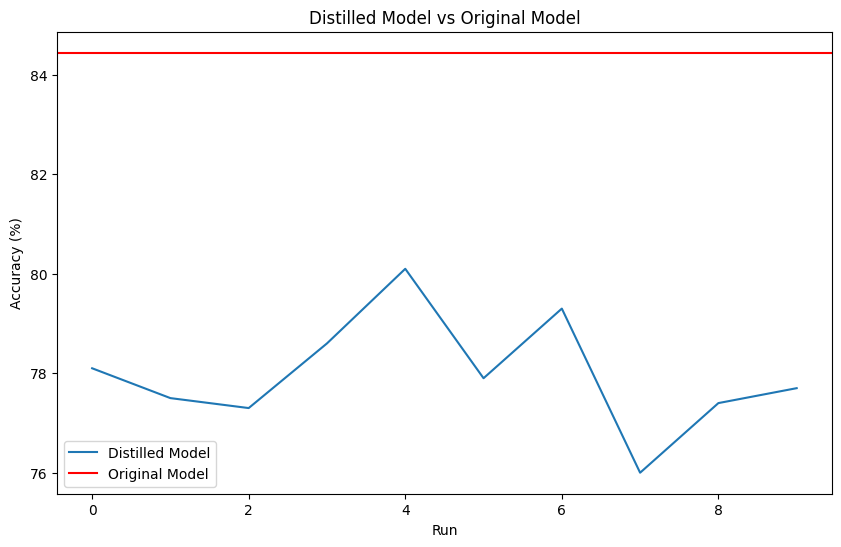

Average Distilled Model Accuracy: 77.99%
Original Model Accuracy: 84.44444444444444%


In [9]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.GridImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=100)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Paralelogram Distillation

C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3325714370526305
Epoch 2/10, Loss: 1.0218559749629519
Epoch 3/10, Loss: 0.7124689494797943
Epoch 4/10, Loss: 0.4559913404764385
Epoch 5/10, Loss: 0.2514470655710325
Epoch 6/10, Loss: 0.1288569985008841
Epoch 7/10, Loss: 0.06799947653273376
Epoch 8/10, Loss: 0.03853435343806418
Epoch 9/10, Loss: 0.020956753395335457
Epoch 10/10, Loss: 0.012423221485949883


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4920581732321223
Epoch 2/10, Loss: 1.1444830615586097
Epoch 3/10, Loss: 0.9429043504076267
Epoch 4/10, Loss: 0.698779403616529
Epoch 5/10, Loss: 0.43798414433221206
Epoch 6/10, Loss: 0.23513575499757713
Epoch 7/10, Loss: 0.12595772433923472
Epoch 8/10, Loss: 0.0809946712063745
Epoch 9/10, Loss: 0.05591633575840281
Epoch 10/10, Loss: 0.05357140645068652


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3165503548919608
Epoch 2/10, Loss: 1.0228785812307934
Epoch 3/10, Loss: 0.7982906663636549
Epoch 4/10, Loss: 0.6113980521849536
Epoch 5/10, Loss: 0.3876142231149411
Epoch 6/10, Loss: 0.23474780377854995
Epoch 7/10, Loss: 0.14586463997806978
Epoch 8/10, Loss: 0.101814216600919
Epoch 9/10, Loss: 0.06501836937194297
Epoch 10/10, Loss: 0.05265440000648346


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4140120033824115
Epoch 2/10, Loss: 1.0726333698001476
Epoch 3/10, Loss: 0.8321158616641245
Epoch 4/10, Loss: 0.6030384337683337
Epoch 5/10, Loss: 0.3830450821086901
Epoch 6/10, Loss: 0.23375909467902753
Epoch 7/10, Loss: 0.13701248408184138
Epoch 8/10, Loss: 0.08807335770048133
Epoch 9/10, Loss: 0.05370757639741337
Epoch 10/10, Loss: 0.030915952016334604


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.2468987457249143
Epoch 2/10, Loss: 0.9585742398139534
Epoch 3/10, Loss: 0.7015313765871416
Epoch 4/10, Loss: 0.4585635651142225
Epoch 5/10, Loss: 0.2658150276733101
Epoch 6/10, Loss: 0.1447129521279707
Epoch 7/10, Loss: 0.0877377923338785
Epoch 8/10, Loss: 0.04909212427393217
Epoch 9/10, Loss: 0.020947573576207964
Epoch 10/10, Loss: 0.02443876487220031


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3183970221685708
Epoch 2/10, Loss: 1.0280741814079635
Epoch 3/10, Loss: 0.8211824166665384
Epoch 4/10, Loss: 0.5434012507353354
Epoch 5/10, Loss: 0.32469057688199054
Epoch 6/10, Loss: 0.18291513683325653
Epoch 7/10, Loss: 0.10483710723288289
Epoch 8/10, Loss: 0.04806292805726717
Epoch 9/10, Loss: 0.030628405853148993
Epoch 10/10, Loss: 0.016606232992997138


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3033064817069868
Epoch 2/10, Loss: 0.972859078591023
Epoch 3/10, Loss: 0.696165542810335
Epoch 4/10, Loss: 0.41211161208808966
Epoch 5/10, Loss: 0.19486040898829426
Epoch 6/10, Loss: 0.10237551330153001
Epoch 7/10, Loss: 0.057299463445782114
Epoch 8/10, Loss: 0.046256568575482986
Epoch 9/10, Loss: 0.05387912908517713
Epoch 10/10, Loss: 0.02734538753209379


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4466164123027696
Epoch 2/10, Loss: 1.1634751197394975
Epoch 3/10, Loss: 0.9405292154998954
Epoch 4/10, Loss: 0.6217907306251176
Epoch 5/10, Loss: 0.34448344116910884
Epoch 6/10, Loss: 0.16483867915193423
Epoch 7/10, Loss: 0.0874794065149142
Epoch 8/10, Loss: 0.0584648488465389
Epoch 9/10, Loss: 0.04262157895926967
Epoch 10/10, Loss: 0.03369687035479028


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.408739421345772
Epoch 2/10, Loss: 1.0618542044534596
Epoch 3/10, Loss: 0.7548968174041958
Epoch 4/10, Loss: 0.44999466877464855
Epoch 5/10, Loss: 0.23375142406706417
Epoch 6/10, Loss: 0.11620096870860376
Epoch 7/10, Loss: 0.053914711434701716
Epoch 8/10, Loss: 0.03884449192331335
Epoch 9/10, Loss: 0.035956394202887605
Epoch 10/10, Loss: 0.028435483544962396


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\303079878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3270519638280256
Epoch 2/10, Loss: 1.0324424406804076
Epoch 3/10, Loss: 0.8836864954834684
Epoch 4/10, Loss: 0.7075267111489533
Epoch 5/10, Loss: 0.584076170527607
Epoch 6/10, Loss: 0.40629887799604225
Epoch 7/10, Loss: 0.28547222481681667
Epoch 8/10, Loss: 0.19099763968805655
Epoch 9/10, Loss: 0.14977195178833577
Epoch 10/10, Loss: 0.1055349954617543


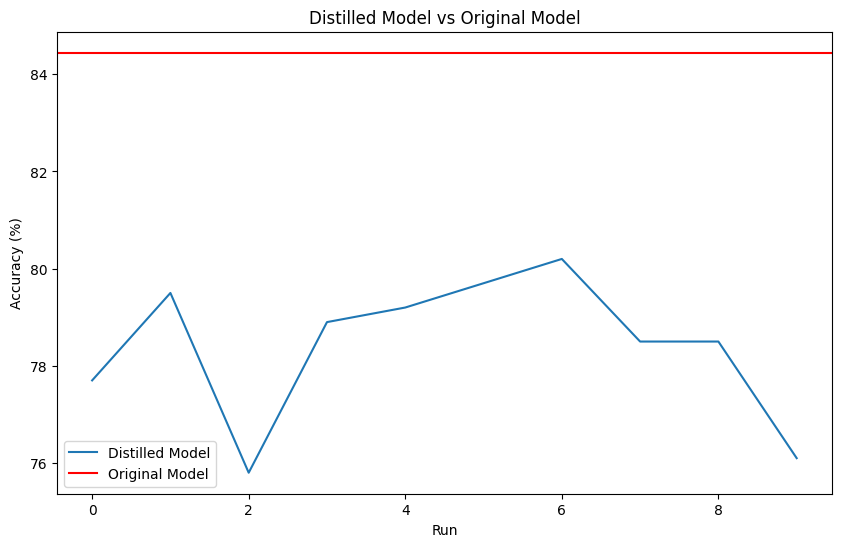

Average Distilled Model Accuracy: 78.41%
Original Model Accuracy: 84.44444444444444%


In [10]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.ParallelogramImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=100)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Triangular Distillation

C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.5083293521076166
Epoch 2/10, Loss: 1.085373374847097
Epoch 3/10, Loss: 0.8459150648991997
Epoch 4/10, Loss: 0.6237812758585729
Epoch 5/10, Loss: 0.39155070333305847
Epoch 6/10, Loss: 0.22136949959698074
Epoch 7/10, Loss: 0.10124115883415445
Epoch 8/10, Loss: 0.06619620940075555
Epoch 9/10, Loss: 0.03417801882200148
Epoch 10/10, Loss: 0.026718299928838986


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.2967147996666235
Epoch 2/10, Loss: 0.98012109141831
Epoch 3/10, Loss: 0.7260045878110676
Epoch 4/10, Loss: 0.4541873637962779
Epoch 5/10, Loss: 0.25566162483407817
Epoch 6/10, Loss: 0.13160300304378392
Epoch 7/10, Loss: 0.08618333571752824
Epoch 8/10, Loss: 0.0594756756396537
Epoch 9/10, Loss: 0.04546714369677554
Epoch 10/10, Loss: 0.03479903464957457


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.2952087625451045
Epoch 2/10, Loss: 0.9778174041608058
Epoch 3/10, Loss: 0.7080400886885617
Epoch 4/10, Loss: 0.45464145467368833
Epoch 5/10, Loss: 0.22592525344786293
Epoch 6/10, Loss: 0.11164968882883908
Epoch 7/10, Loss: 0.046276937939500044
Epoch 8/10, Loss: 0.03459042715498272
Epoch 9/10, Loss: 0.0324471236095516
Epoch 10/10, Loss: 0.021626118472307373


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.337391178542321
Epoch 2/10, Loss: 1.0212774850906583
Epoch 3/10, Loss: 0.7845083801844798
Epoch 4/10, Loss: 0.542656773274098
Epoch 5/10, Loss: 0.3383858174495741
Epoch 6/10, Loss: 0.18606685105403628
Epoch 7/10, Loss: 0.11871752681193548
Epoch 8/10, Loss: 0.05248544951302743
Epoch 9/10, Loss: 0.041312269652860424
Epoch 10/10, Loss: 0.03088618799565582


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3465066907602712
Epoch 2/10, Loss: 0.9780547093907628
Epoch 3/10, Loss: 0.6509168093357611
Epoch 4/10, Loss: 0.3632334865834735
Epoch 5/10, Loss: 0.1835019744317466
Epoch 6/10, Loss: 0.09962809364388295
Epoch 7/10, Loss: 0.061612533841179595
Epoch 8/10, Loss: 0.041714233448814364
Epoch 9/10, Loss: 0.04913965310610899
Epoch 10/10, Loss: 0.03169028305687831


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.2812594065972425
Epoch 2/10, Loss: 0.9063925199005582
Epoch 3/10, Loss: 0.5591573391212236
Epoch 4/10, Loss: 0.2737789755567498
Epoch 5/10, Loss: 0.1177173671269909
Epoch 6/10, Loss: 0.06142542599230458
Epoch 7/10, Loss: 0.04063822040782917
Epoch 8/10, Loss: 0.034514676886311636
Epoch 9/10, Loss: 0.023897455621792706
Epoch 10/10, Loss: 0.07102955422799932


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3380253314971924
Epoch 2/10, Loss: 1.0577779565382441
Epoch 3/10, Loss: 0.8389153871514382
Epoch 4/10, Loss: 0.5916507369881376
Epoch 5/10, Loss: 0.3144784193793568
Epoch 6/10, Loss: 0.20304656708869365
Epoch 7/10, Loss: 0.1059916399145892
Epoch 8/10, Loss: 0.06085974817941769
Epoch 9/10, Loss: 0.051761661297342644
Epoch 10/10, Loss: 0.04754182180910961


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3241268292479558
Epoch 2/10, Loss: 0.9281977765057066
Epoch 3/10, Loss: 0.6199196880563683
Epoch 4/10, Loss: 0.3272180147127274
Epoch 5/10, Loss: 0.16063039573849341
Epoch 6/10, Loss: 0.09230952732448697
Epoch 7/10, Loss: 0.042929914102829786
Epoch 8/10, Loss: 0.04066662697565802
Epoch 9/10, Loss: 0.02226797252153303
Epoch 10/10, Loss: 0.028377690565571566


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3362432417519596
Epoch 2/10, Loss: 0.9866351036850466
Epoch 3/10, Loss: 0.7627748475162262
Epoch 4/10, Loss: 0.5018143257416716
Epoch 5/10, Loss: 0.27008560170000845
Epoch 6/10, Loss: 0.13361059805942238
Epoch 7/10, Loss: 0.10323911463551291
Epoch 8/10, Loss: 0.062959314298329
Epoch 9/10, Loss: 0.028647458575956457
Epoch 10/10, Loss: 0.026894663571627862


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2379853641.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3574946150867218
Epoch 2/10, Loss: 1.0358538042514696
Epoch 3/10, Loss: 0.8326856638860265
Epoch 4/10, Loss: 0.5822887502679037
Epoch 5/10, Loss: 0.31209995522411593
Epoch 6/10, Loss: 0.16135572686518004
Epoch 7/10, Loss: 0.08200230968928118
Epoch 8/10, Loss: 0.04602825755697735
Epoch 9/10, Loss: 0.02619517242125825
Epoch 10/10, Loss: 0.021446779196218953


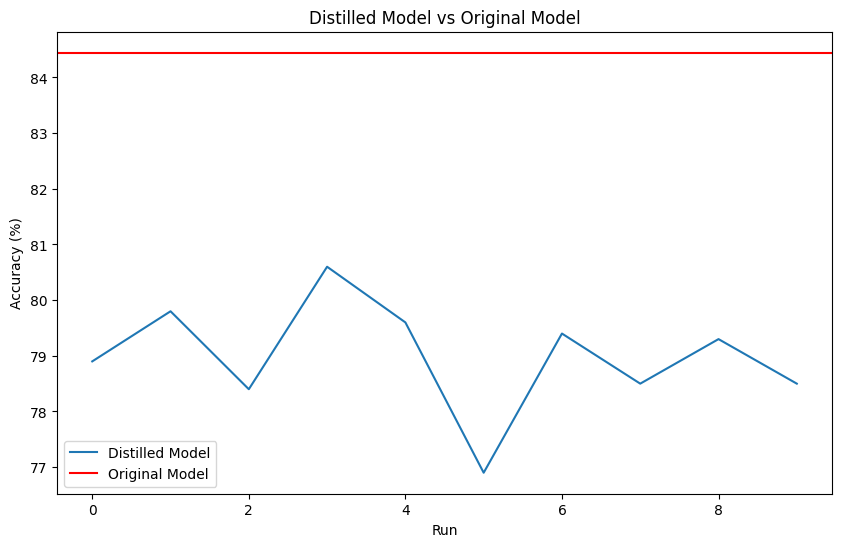

Average Distilled Model Accuracy: 78.98999999999998%
Original Model Accuracy: 84.44444444444444%


In [11]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.TriangularImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=100)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Brick Distillation

C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.268312312047416
Epoch 2/10, Loss: 0.9155426167566841
Epoch 3/10, Loss: 0.6498574360248146
Epoch 4/10, Loss: 0.4104491175588118
Epoch 5/10, Loss: 0.20650038143636984
Epoch 6/10, Loss: 0.10363522682919962
Epoch 7/10, Loss: 0.061919164049242616
Epoch 8/10, Loss: 0.03769841829075589
Epoch 9/10, Loss: 0.032286481927533486
Epoch 10/10, Loss: 0.05694544949534631


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.2932992572084478
Epoch 2/10, Loss: 0.9692750190376141
Epoch 3/10, Loss: 0.6655841070577639
Epoch 4/10, Loss: 0.36732460633603803
Epoch 5/10, Loss: 0.1663268114687926
Epoch 6/10, Loss: 0.08778916895731327
Epoch 7/10, Loss: 0.04895328073185621
Epoch 8/10, Loss: 0.026377287481851672
Epoch 9/10, Loss: 0.021114311067797584
Epoch 10/10, Loss: 0.012609275159908784


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3421963732176965
Epoch 2/10, Loss: 1.0184263286240605
Epoch 3/10, Loss: 0.7709813358586862
Epoch 4/10, Loss: 0.4629028048537193
Epoch 5/10, Loss: 0.23517391970808352
Epoch 6/10, Loss: 0.11237274807527525
Epoch 7/10, Loss: 0.0651404954954435
Epoch 8/10, Loss: 0.05428946191667143
Epoch 9/10, Loss: 0.03365942918900571
Epoch 10/10, Loss: 0.02582032481046103


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3509999065224183
Epoch 2/10, Loss: 0.9993167013750164
Epoch 3/10, Loss: 0.6985264770481565
Epoch 4/10, Loss: 0.4285855913927796
Epoch 5/10, Loss: 0.24453620838189344
Epoch 6/10, Loss: 0.1315834619309924
Epoch 7/10, Loss: 0.07207896474988089
Epoch 8/10, Loss: 0.052679462187470646
Epoch 9/10, Loss: 0.0311950976926184
Epoch 10/10, Loss: 0.03350863624428219


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3424938966374877
Epoch 2/10, Loss: 0.9593716001291888
Epoch 3/10, Loss: 0.6199920346977514
Epoch 4/10, Loss: 0.31755561190187387
Epoch 5/10, Loss: 0.16670735670817555
Epoch 6/10, Loss: 0.08019549893471625
Epoch 7/10, Loss: 0.054350003377970205
Epoch 8/10, Loss: 0.04327162987351794
Epoch 9/10, Loss: 0.024452910696609167
Epoch 10/10, Loss: 0.029412273926352827


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3920019279926195
Epoch 2/10, Loss: 1.1068561427090147
Epoch 3/10, Loss: 0.927538418988569
Epoch 4/10, Loss: 0.7226378682556502
Epoch 5/10, Loss: 0.5077666023729044
Epoch 6/10, Loss: 0.3066929202492631
Epoch 7/10, Loss: 0.19852629808042574
Epoch 8/10, Loss: 0.13143569661663213
Epoch 9/10, Loss: 0.07370973376283815
Epoch 10/10, Loss: 0.046719254814771884


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3158643705035569
Epoch 2/10, Loss: 0.9215810555930531
Epoch 3/10, Loss: 0.6168014541131641
Epoch 4/10, Loss: 0.3579564460920631
Epoch 5/10, Loss: 0.1699765127904098
Epoch 6/10, Loss: 0.07438150434882952
Epoch 7/10, Loss: 0.04833427861913902
Epoch 8/10, Loss: 0.03861831751686239
Epoch 9/10, Loss: 0.027693432127232364
Epoch 10/10, Loss: 0.02029920197700774


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3191611630107285
Epoch 2/10, Loss: 0.9928350886073681
Epoch 3/10, Loss: 0.7422489119232247
Epoch 4/10, Loss: 0.46001904177556346
Epoch 5/10, Loss: 0.2587617393070405
Epoch 6/10, Loss: 0.12909135275409309
Epoch 7/10, Loss: 0.07765025821933096
Epoch 8/10, Loss: 0.03837870978622125
Epoch 9/10, Loss: 0.033068839326039504
Epoch 10/10, Loss: 0.01862364096156911


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.3635747755339387
Epoch 2/10, Loss: 1.031322116698694
Epoch 3/10, Loss: 0.8436825368382516
Epoch 4/10, Loss: 0.599351195293829
Epoch 5/10, Loss: 0.38506607205495924
Epoch 6/10, Loss: 0.21818989569987726
Epoch 7/10, Loss: 0.12037035686160447
Epoch 8/10, Loss: 0.09098037364764498
Epoch 9/10, Loss: 0.07452066033788093
Epoch 10/10, Loss: 0.044989045850351586


C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\4071374373.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 1.4050223969538278
Epoch 2/10, Loss: 1.0404776001195295
Epoch 3/10, Loss: 0.7472566899356492
Epoch 4/10, Loss: 0.4325500980976525
Epoch 5/10, Loss: 0.21935167587404952
Epoch 6/10, Loss: 0.11473528329932361
Epoch 7/10, Loss: 0.06745217187723163
Epoch 8/10, Loss: 0.07959078484718952
Epoch 9/10, Loss: 0.03970053266101611
Epoch 10/10, Loss: 0.024973232241415785


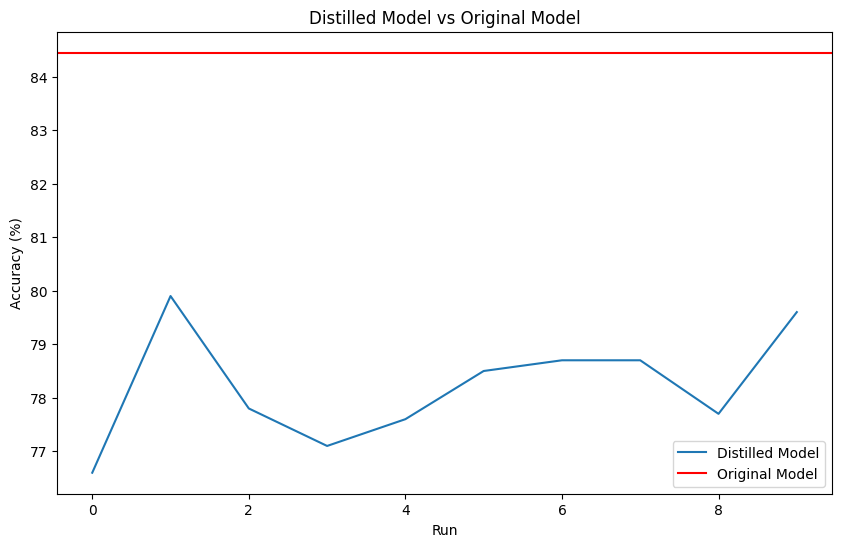

Average Distilled Model Accuracy: 78.22%
Original Model Accuracy: 84.44444444444444%


In [12]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.BrickImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=100)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


# Demo - Gender

In [13]:
# define the dataset 
gender = ["MEN", "WOMAN"]
path = 'C:\\Users\\Hp\\summer_projects\\datasets\\gender\\'

# load the dataset
dataset = []
for i, gen in enumerate(gender):
    print(f'Processing {gen} images...')
    gen_dir = os.path.join(path, gen)
    for file in os.listdir(gen_dir):
        image_path = os.path.join(gen_dir, file)
        image = Image.open(image_path)
        image = image.resize((128, 128))  # Resize images to (128, 128)
        dataset.append((np.array(image), i))

# Shuffle the dataset
np.random.shuffle(dataset)

# Split the dataset into images and labels
X = np.array([x[0] for x in dataset], dtype=np.float32) / 255.0
y = np.array([x[1] for x in dataset], dtype=np.int64)

# Convert images to torch tensors
X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)  # Reshape to (N, C, H, W)
y = torch.tensor(y, dtype=torch.long)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, criterion, optimizer, epochs=10)

# Evaluate the model
accuracy = evaluate(model, test_loader)

print(f'Original Model Accuracy: {accuracy}%')

Processing MEN images...
Processing WOMAN images...
Epoch 1/10, Loss: 0.7172293807521011
Epoch 2/10, Loss: 0.611305240428809
Epoch 3/10, Loss: 0.5528777313954902
Epoch 4/10, Loss: 0.4789534328561841
Epoch 5/10, Loss: 0.41452725186492456
Epoch 6/10, Loss: 0.3551538609194033
Epoch 7/10, Loss: 0.2862677321289525
Epoch 8/10, Loss: 0.24143515075698044
Epoch 9/10, Loss: 0.1893996995958415
Epoch 10/10, Loss: 0.10751155199426593
Original Model Accuracy: 72.58687258687259%


## Grid Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8474658049386123
Epoch 2/10, Loss: 0.5981039281549125
Epoch 3/10, Loss: 0.5351268823804527
Epoch 4/10, Loss: 0.46662381907989237
Epoch 5/10, Loss: 0.41962582900606354
Epoch 6/10, Loss: 0.3607236686451682
Epoch 7/10, Loss: 0.2946889580323778
Epoch 8/10, Loss: 0.19583753136725263
Epoch 9/10, Loss: 0.1704383471916462
Epoch 10/10, Loss: 0.10816953369769557


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7048950770805622
Epoch 2/10, Loss: 0.5556128610824717
Epoch 3/10, Loss: 0.4568019776508726
Epoch 4/10, Loss: 0.35692994245167436
Epoch 5/10, Loss: 0.29690595793312996
Epoch 6/10, Loss: 0.17601032426645016
Epoch 7/10, Loss: 0.11415775377174904
Epoch 8/10, Loss: 0.08233728921362038
Epoch 9/10, Loss: 0.045794723523331096
Epoch 10/10, Loss: 0.030736288762298124


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.713722810663026
Epoch 2/10, Loss: 0.5313927192112495
Epoch 3/10, Loss: 0.4683989265869404
Epoch 4/10, Loss: 0.4073284710275716
Epoch 5/10, Loss: 0.27887994975879277
Epoch 6/10, Loss: 0.18202255743330922
Epoch 7/10, Loss: 0.10253187307509883
Epoch 8/10, Loss: 0.05725952963633784
Epoch 9/10, Loss: 0.022375307864798553
Epoch 10/10, Loss: 0.009662903066531852


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7337445534508804
Epoch 2/10, Loss: 0.611765671392967
Epoch 3/10, Loss: 0.5405272070703835
Epoch 4/10, Loss: 0.47329729692689304
Epoch 5/10, Loss: 0.3769911753720251
Epoch 6/10, Loss: 0.2927041567605117
Epoch 7/10, Loss: 0.2160681838105465
Epoch 8/10, Loss: 0.13140829292864636
Epoch 9/10, Loss: 0.07786255194966135
Epoch 10/10, Loss: 0.03715963658459227


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8184154485834056
Epoch 2/10, Loss: 0.6293382120543513
Epoch 3/10, Loss: 0.5726665967497332
Epoch 4/10, Loss: 0.5228625443475
Epoch 5/10, Loss: 0.46456018295781365
Epoch 6/10, Loss: 0.4078292045099982
Epoch 7/10, Loss: 0.3129201849986767
Epoch 8/10, Loss: 0.24674667726302968
Epoch 9/10, Loss: 0.16352506855438495
Epoch 10/10, Loss: 0.11571199395533266


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.730677370367379
Epoch 2/10, Loss: 0.5640047182296885
Epoch 3/10, Loss: 0.4709382786833007
Epoch 4/10, Loss: 0.3978901371873658
Epoch 5/10, Loss: 0.2773965661381853
Epoch 6/10, Loss: 0.21193254661971125
Epoch 7/10, Loss: 0.13057121210570993
Epoch 8/10, Loss: 0.07048047343590136
Epoch 9/10, Loss: 0.039498215517157625
Epoch 10/10, Loss: 0.016043365073936253


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.9213155364168102
Epoch 2/10, Loss: 0.6628052160657686
Epoch 3/10, Loss: 0.5729078136641403
Epoch 4/10, Loss: 0.4990253458762991
Epoch 5/10, Loss: 0.45840659840353604
Epoch 6/10, Loss: 0.3594792665078722
Epoch 7/10, Loss: 0.30189015074022885
Epoch 8/10, Loss: 0.20167668600534572
Epoch 9/10, Loss: 0.12758470018362178
Epoch 10/10, Loss: 0.07593655380709417


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.6908646102609306
Epoch 2/10, Loss: 0.576606383611416
Epoch 3/10, Loss: 0.5127520797581508
Epoch 4/10, Loss: 0.44986478727439355
Epoch 5/10, Loss: 0.3360414618048175
Epoch 6/10, Loss: 0.2526656065521569
Epoch 7/10, Loss: 0.17112282124058953
Epoch 8/10, Loss: 0.09992476282962437
Epoch 9/10, Loss: 0.0765957770034157
Epoch 10/10, Loss: 0.03258943800204273


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7249574291295019
Epoch 2/10, Loss: 0.5730533096297034
Epoch 3/10, Loss: 0.48725272972008277
Epoch 4/10, Loss: 0.43376506505341367
Epoch 5/10, Loss: 0.3649967271706154
Epoch 6/10, Loss: 0.30658051422957716
Epoch 7/10, Loss: 0.23296859346587082
Epoch 8/10, Loss: 0.15217756325828619
Epoch 9/10, Loss: 0.11819299098489613
Epoch 10/10, Loss: 0.06536862527116619


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2577628228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7803473472595215
Epoch 2/10, Loss: 0.6106266235483104
Epoch 3/10, Loss: 0.5190838893939709
Epoch 4/10, Loss: 0.43553262537923354
Epoch 5/10, Loss: 0.34011824531801815
Epoch 6/10, Loss: 0.2763868971117612
Epoch 7/10, Loss: 0.1964869499206543
Epoch 8/10, Loss: 0.1965285411168789
Epoch 9/10, Loss: 0.12101910879899716
Epoch 10/10, Loss: 0.08342492785947077


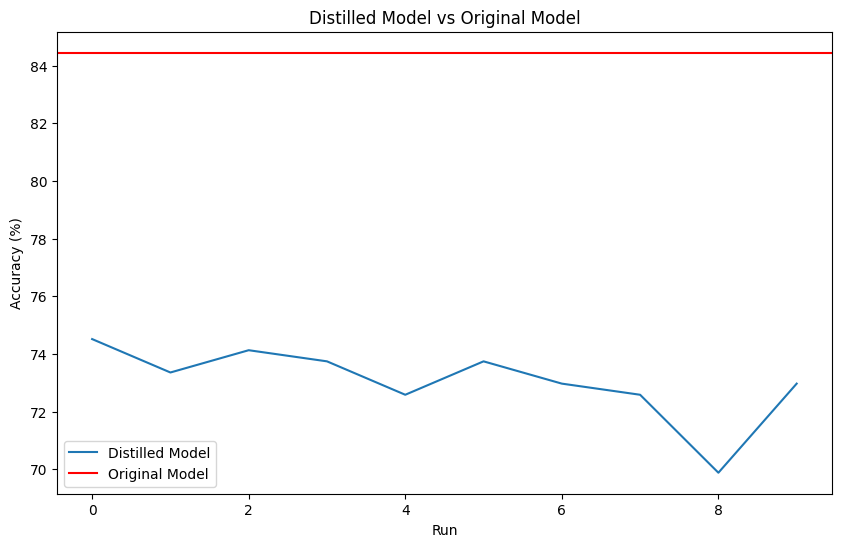

Average Distilled Model Accuracy: 73.05019305019304%
Original Model Accuracy: 84.44444444444444%


In [14]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.GridImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=60)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Paralelogram Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7111620368628666
Epoch 2/10, Loss: 0.614456832408905
Epoch 3/10, Loss: 0.5297078366937309
Epoch 4/10, Loss: 0.4214762778117739
Epoch 5/10, Loss: 0.3082522441600931
Epoch 6/10, Loss: 0.21376917613991375
Epoch 7/10, Loss: 0.12455042156166043
Epoch 8/10, Loss: 0.06868350871934972
Epoch 9/10, Loss: 0.027805926968696815
Epoch 10/10, Loss: 0.014297701595029954


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8835670372535442
Epoch 2/10, Loss: 0.6826560579497238
Epoch 3/10, Loss: 0.6200390889726836
Epoch 4/10, Loss: 0.5872231310811536
Epoch 5/10, Loss: 0.5155516256546152
Epoch 6/10, Loss: 0.46356557463777476
Epoch 7/10, Loss: 0.37063197431893186
Epoch 8/10, Loss: 0.28935092225156983
Epoch 9/10, Loss: 0.21262264637083844
Epoch 10/10, Loss: 0.14817924309393454


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8187866498684061
Epoch 2/10, Loss: 0.6454014983670465
Epoch 3/10, Loss: 0.5652273317863201
Epoch 4/10, Loss: 0.502653025347611
Epoch 5/10, Loss: 0.3999855723874322
Epoch 6/10, Loss: 0.31297852921074837
Epoch 7/10, Loss: 0.21952892711450314
Epoch 8/10, Loss: 0.14278858835841046
Epoch 9/10, Loss: 0.0813181830634331
Epoch 10/10, Loss: 0.03761125696373397


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7286281462373405
Epoch 2/10, Loss: 0.595345903059532
Epoch 3/10, Loss: 0.5331788957118988
Epoch 4/10, Loss: 0.46587490007795135
Epoch 5/10, Loss: 0.3494168889933619
Epoch 6/10, Loss: 0.2608766668829425
Epoch 7/10, Loss: 0.1482976957641799
Epoch 8/10, Loss: 0.07555423163134477
Epoch 9/10, Loss: 0.02681161469683565
Epoch 10/10, Loss: 0.017966420662685716


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7757252351991062
Epoch 2/10, Loss: 0.6570642611076092
Epoch 3/10, Loss: 0.5623172552421175
Epoch 4/10, Loss: 0.4879363929403239
Epoch 5/10, Loss: 0.43729050406094255
Epoch 6/10, Loss: 0.3555765239329174
Epoch 7/10, Loss: 0.26331378519535065
Epoch 8/10, Loss: 0.1879601712370741
Epoch 9/10, Loss: 0.09940947386725195
Epoch 10/10, Loss: 0.04797397640630089


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7581756443812929
Epoch 2/10, Loss: 0.6250895549511087
Epoch 3/10, Loss: 0.5629717142417513
Epoch 4/10, Loss: 0.5152210099943753
Epoch 5/10, Loss: 0.5001873754221817
Epoch 6/10, Loss: 0.3856181301947298
Epoch 7/10, Loss: 0.32371718770471114
Epoch 8/10, Loss: 0.2162199847657105
Epoch 9/10, Loss: 0.14083001981007642
Epoch 10/10, Loss: 0.09042951092123985


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7380115245950634
Epoch 2/10, Loss: 0.6291008725248534
Epoch 3/10, Loss: 0.5496840107029882
Epoch 4/10, Loss: 0.4737614290467624
Epoch 5/10, Loss: 0.3288621774007534
Epoch 6/10, Loss: 0.24696155149361182
Epoch 7/10, Loss: 0.15299202951377835
Epoch 8/10, Loss: 0.0943840291864913
Epoch 9/10, Loss: 0.03548447726744002
Epoch 10/10, Loss: 0.016113772956204826


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.753402829170227
Epoch 2/10, Loss: 0.6301858980080177
Epoch 3/10, Loss: 0.5473595169083826
Epoch 4/10, Loss: 0.48369849550312966
Epoch 5/10, Loss: 0.4164488356688927
Epoch 6/10, Loss: 0.3259592945205754
Epoch 7/10, Loss: 0.28387066208083056
Epoch 8/10, Loss: 0.20489885966325627
Epoch 9/10, Loss: 0.1387407061611784
Epoch 10/10, Loss: 0.09221911199133971


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7352908192009762
Epoch 2/10, Loss: 0.5994428581204908
Epoch 3/10, Loss: 0.5117506569829481
Epoch 4/10, Loss: 0.43435773767274
Epoch 5/10, Loss: 0.36829260402712327
Epoch 6/10, Loss: 0.26732791395022953
Epoch 7/10, Loss: 0.1948266114140379
Epoch 8/10, Loss: 0.11783607728008566
Epoch 9/10, Loss: 0.06971658824075913
Epoch 10/10, Loss: 0.03177183728408197


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1061059052.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7081041849892715
Epoch 2/10, Loss: 0.5940548592600329
Epoch 3/10, Loss: 0.5067153953272721
Epoch 4/10, Loss: 0.45337587492219333
Epoch 5/10, Loss: 0.35122679996079414
Epoch 6/10, Loss: 0.2537168415969816
Epoch 7/10, Loss: 0.1924751409939651
Epoch 8/10, Loss: 0.1250272853107288
Epoch 9/10, Loss: 0.07591572904895091
Epoch 10/10, Loss: 0.03683319967240095


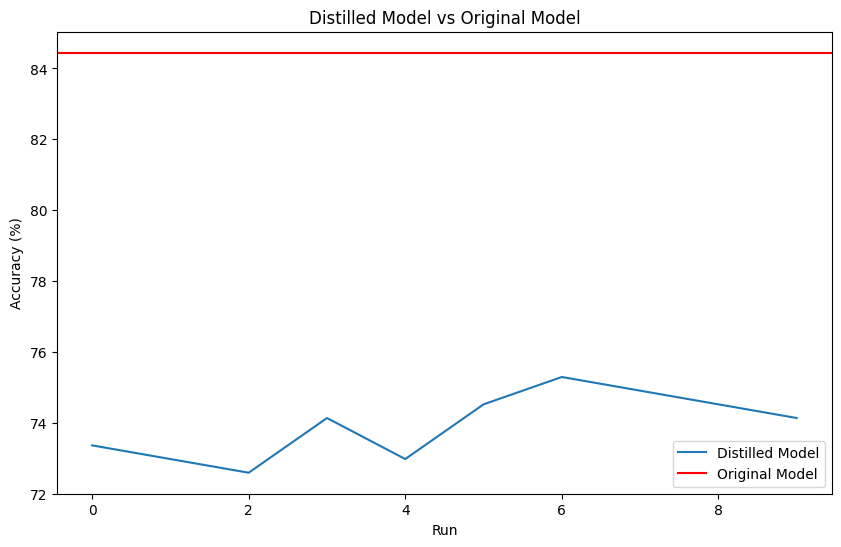

Average Distilled Model Accuracy: 73.93822393822394%
Original Model Accuracy: 84.44444444444444%


In [15]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.ParallelogramImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=60)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Triangular Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.6908022596918303
Epoch 2/10, Loss: 0.612894306922781
Epoch 3/10, Loss: 0.5436312720693391
Epoch 4/10, Loss: 0.46674907824088785
Epoch 5/10, Loss: 0.4212985069587313
Epoch 6/10, Loss: 0.3446838490921876
Epoch 7/10, Loss: 0.2492814053749216
Epoch 8/10, Loss: 0.15664916408473048
Epoch 9/10, Loss: 0.07964518855743367
Epoch 10/10, Loss: 0.03300214057852482


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8131892002862076
Epoch 2/10, Loss: 0.6475078648534315
Epoch 3/10, Loss: 0.5968908225667888
Epoch 4/10, Loss: 0.5533253324442896
Epoch 5/10, Loss: 0.4802904899778037
Epoch 6/10, Loss: 0.4313312604509551
Epoch 7/10, Loss: 0.3528783228890649
Epoch 8/10, Loss: 0.3100188749617544
Epoch 9/10, Loss: 0.24557406480970054
Epoch 10/10, Loss: 0.14615508888302178


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7311250896289431
Epoch 2/10, Loss: 0.608312406416597
Epoch 3/10, Loss: 0.5543559861594233
Epoch 4/10, Loss: 0.49702503455096275
Epoch 5/10, Loss: 0.46055975659140225
Epoch 6/10, Loss: 0.3987423777580261
Epoch 7/10, Loss: 0.3273868355257758
Epoch 8/10, Loss: 0.2567325881842909
Epoch 9/10, Loss: 0.20057996593672653
Epoch 10/10, Loss: 0.13036419849457412


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7259734416830128
Epoch 2/10, Loss: 0.6225495605633177
Epoch 3/10, Loss: 0.5548610111762737
Epoch 4/10, Loss: 0.4776856200448398
Epoch 5/10, Loss: 0.37989293963744725
Epoch 6/10, Loss: 0.2643518576334263
Epoch 7/10, Loss: 0.18196167334400373
Epoch 8/10, Loss: 0.1110307479213024
Epoch 9/10, Loss: 0.07500398364560358
Epoch 10/10, Loss: 0.06858702068184984


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7573109145822197
Epoch 2/10, Loss: 0.6080681506929726
Epoch 3/10, Loss: 0.5302387537627384
Epoch 4/10, Loss: 0.43980480062550514
Epoch 5/10, Loss: 0.3574673564269625
Epoch 6/10, Loss: 0.24300451062876602
Epoch 7/10, Loss: 0.16406026431198778
Epoch 8/10, Loss: 0.09486501946531493
Epoch 9/10, Loss: 0.05851463922138872
Epoch 10/10, Loss: 0.021508365805292952


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8195638348316324
Epoch 2/10, Loss: 0.6278100034286236
Epoch 3/10, Loss: 0.555568509060761
Epoch 4/10, Loss: 0.4900853767477233
Epoch 5/10, Loss: 0.44322267894087164
Epoch 6/10, Loss: 0.38917762092475233
Epoch 7/10, Loss: 0.30263256307305963
Epoch 8/10, Loss: 0.24202726318918424
Epoch 9/10, Loss: 0.15835288989132848
Epoch 10/10, Loss: 0.07681196985830521


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.712884052046414
Epoch 2/10, Loss: 0.6212110406365888
Epoch 3/10, Loss: 0.5160031441984505
Epoch 4/10, Loss: 0.4441218088413107
Epoch 5/10, Loss: 0.363328730237895
Epoch 6/10, Loss: 0.26144357102698296
Epoch 7/10, Loss: 0.18577457707503747
Epoch 8/10, Loss: 0.11136023244210358
Epoch 9/10, Loss: 0.06061626392705687
Epoch 10/10, Loss: 0.03207128433960265


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.9301504574973007
Epoch 2/10, Loss: 0.6910574395081093
Epoch 3/10, Loss: 0.6462852934311176
Epoch 4/10, Loss: 0.5837221012033266
Epoch 5/10, Loss: 0.5395967539014488
Epoch 6/10, Loss: 0.488248735666275
Epoch 7/10, Loss: 0.4325397179044526
Epoch 8/10, Loss: 0.3578494854014495
Epoch 9/10, Loss: 0.2933985298049861
Epoch 10/10, Loss: 0.18915007905713443


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.6848538661825245
Epoch 2/10, Loss: 0.5769949421800417
Epoch 3/10, Loss: 0.4853393743778097
Epoch 4/10, Loss: 0.4089252522279476
Epoch 5/10, Loss: 0.3116640397186937
Epoch 6/10, Loss: 0.22252236486508928
Epoch 7/10, Loss: 0.1427854142826179
Epoch 8/10, Loss: 0.08489445365708449
Epoch 9/10, Loss: 0.05582020592329831
Epoch 10/10, Loss: 0.026675443967868542


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\2387970315.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7057960465036589
Epoch 2/10, Loss: 0.5794108725827316
Epoch 3/10, Loss: 0.5231709161709095
Epoch 4/10, Loss: 0.449685623933529
Epoch 5/10, Loss: 0.3482562282989765
Epoch 6/10, Loss: 0.2579050762899991
Epoch 7/10, Loss: 0.17240948461253067
Epoch 8/10, Loss: 0.13504132461445084
Epoch 9/10, Loss: 0.05134566805871396
Epoch 10/10, Loss: 0.0365535921320833


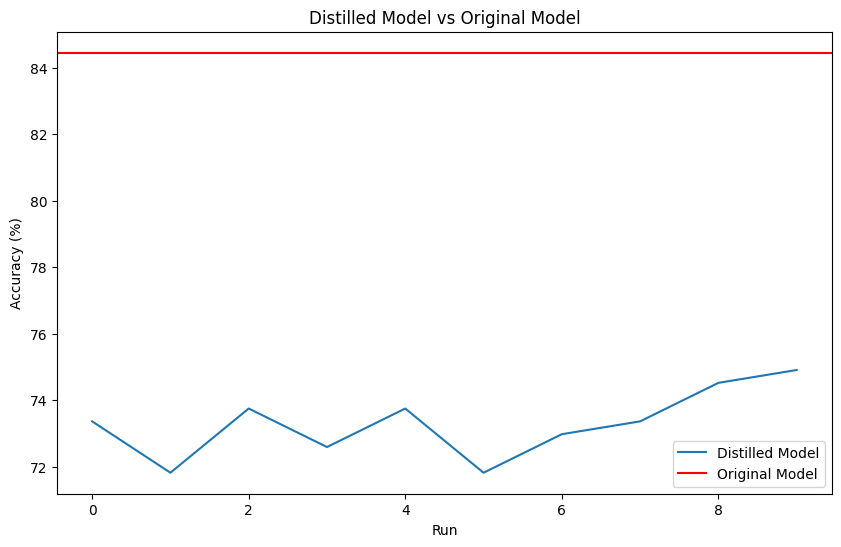

Average Distilled Model Accuracy: 73.28185328185329%
Original Model Accuracy: 84.44444444444444%


In [16]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.TriangularImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=60)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')


## Brick Distillation

c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.6988987398558649
Epoch 2/10, Loss: 0.5098521935528723
Epoch 3/10, Loss: 0.44060251219519253
Epoch 4/10, Loss: 0.3446022128236705
Epoch 5/10, Loss: 0.26597560839406376
Epoch 6/10, Loss: 0.1718638946527037
Epoch 7/10, Loss: 0.1029060360943449
Epoch 8/10, Loss: 0.044490528838901686
Epoch 9/10, Loss: 0.01881826681823566
Epoch 10/10, Loss: 0.007860006226612062


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7335350883418116
Epoch 2/10, Loss: 0.5929021383153981
Epoch 3/10, Loss: 0.4791774194816063
Epoch 4/10, Loss: 0.37762291934983483
Epoch 5/10, Loss: 0.3021829066605404
Epoch 6/10, Loss: 0.20560955872823453
Epoch 7/10, Loss: 0.12259917988859374
Epoch 8/10, Loss: 0.071411131014084
Epoch 9/10, Loss: 0.05194769851092634
Epoch 10/10, Loss: 0.049715321254113626


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7526501704906595
Epoch 2/10, Loss: 0.6143213325533373
Epoch 3/10, Loss: 0.5547655954443175
Epoch 4/10, Loss: 0.507642647315716
Epoch 5/10, Loss: 0.43731253825384997
Epoch 6/10, Loss: 0.3816453382886689
Epoch 7/10, Loss: 0.31099339754417027
Epoch 8/10, Loss: 0.22000898395119042
Epoch 9/10, Loss: 0.16464784124801898
Epoch 10/10, Loss: 0.10348063187095626


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7007031646268121
Epoch 2/10, Loss: 0.5273678066401646
Epoch 3/10, Loss: 0.408271753068628
Epoch 4/10, Loss: 0.3949801145956434
Epoch 5/10, Loss: 0.2770857322832634
Epoch 6/10, Loss: 0.1740896619599441
Epoch 7/10, Loss: 0.12422425158578775
Epoch 8/10, Loss: 0.05935458928860467
Epoch 9/10, Loss: 0.03094687751205317
Epoch 10/10, Loss: 0.02105511123603531


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7271078598910364
Epoch 2/10, Loss: 0.5806735342946546
Epoch 3/10, Loss: 0.5543705379140789
Epoch 4/10, Loss: 0.5057525172315794
Epoch 5/10, Loss: 0.42752937510095795
Epoch 6/10, Loss: 0.35601143179268674
Epoch 7/10, Loss: 0.2654743903669818
Epoch 8/10, Loss: 0.1746644601225853
Epoch 9/10, Loss: 0.11278015490749786
Epoch 10/10, Loss: 0.05736966260933671


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7700300812721252
Epoch 2/10, Loss: 0.6547453321259598
Epoch 3/10, Loss: 0.5689334828278114
Epoch 4/10, Loss: 0.4932205707862459
Epoch 5/10, Loss: 0.4097235665239137
Epoch 6/10, Loss: 0.3210005133316435
Epoch 7/10, Loss: 0.22937057501283184
Epoch 8/10, Loss: 0.14560326587023406
Epoch 9/10, Loss: 0.10506878947389536
Epoch 10/10, Loss: 0.04096832055726956


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7750911466006575
Epoch 2/10, Loss: 0.639485527729166
Epoch 3/10, Loss: 0.5592145036006796
Epoch 4/10, Loss: 0.5462953962128738
Epoch 5/10, Loss: 0.5057827285651503
Epoch 6/10, Loss: 0.44954026207841674
Epoch 7/10, Loss: 0.40217254233771355
Epoch 8/10, Loss: 0.33461850727426595
Epoch 9/10, Loss: 0.29066559209905823
Epoch 10/10, Loss: 0.2100616536777595


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8551855560006767
Epoch 2/10, Loss: 0.6156424900581097
Epoch 3/10, Loss: 0.5339964957072817
Epoch 4/10, Loss: 0.46127232909202576
Epoch 5/10, Loss: 0.41728612677804355
Epoch 6/10, Loss: 0.3557449908092104
Epoch 7/10, Loss: 0.28390102550901214
Epoch 8/10, Loss: 0.252327392584291
Epoch 9/10, Loss: 0.1810725400673932
Epoch 10/10, Loss: 0.1341915273203932


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.8710630823825968
Epoch 2/10, Loss: 0.6558606686263249
Epoch 3/10, Loss: 0.5993822607500799
Epoch 4/10, Loss: 0.566157533177014
Epoch 5/10, Loss: 0.535940927678141
Epoch 6/10, Loss: 0.5117135859768966
Epoch 7/10, Loss: 0.45602024012598497
Epoch 8/10, Loss: 0.39119786126860256
Epoch 9/10, Loss: 0.3697606787599366
Epoch 10/10, Loss: 0.28183329310910454


c:\Users\Hp\anaconda3\envs\cuda_deneme\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_7344\1511781321.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)


Epoch 1/10, Loss: 0.7644870527859392
Epoch 2/10, Loss: 0.6078265165460521
Epoch 3/10, Loss: 0.506526373583695
Epoch 4/10, Loss: 0.4514890292595173
Epoch 5/10, Loss: 0.3381761240548101
Epoch 6/10, Loss: 0.24933097485838265
Epoch 7/10, Loss: 0.19523270762172237
Epoch 8/10, Loss: 0.16005437255933366
Epoch 9/10, Loss: 0.08585289583123963
Epoch 10/10, Loss: 0.033394266433756925


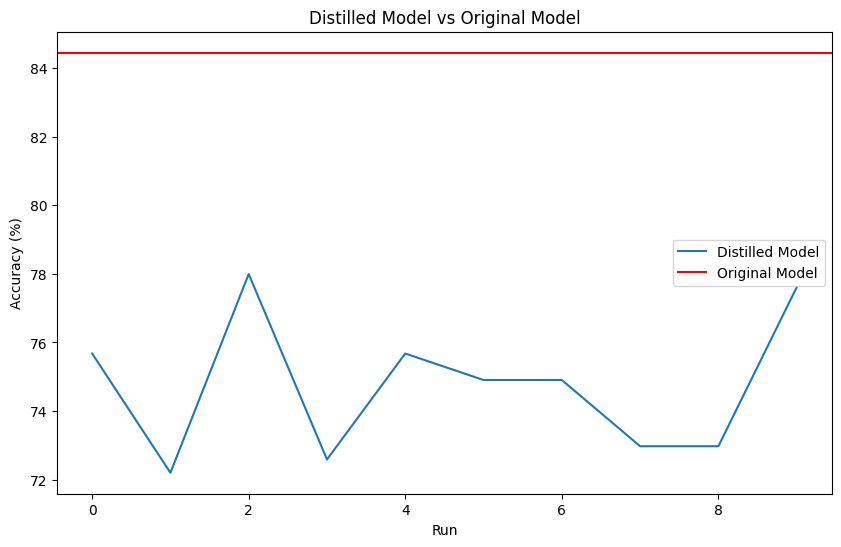

Average Distilled Model Accuracy: 74.74903474903473%
Original Model Accuracy: 84.44444444444444%


In [17]:
n_runs = 10
distilled_accuracies = list()
original_accuracies = list()

for i in range(n_runs):
    grid_sampler = gd.BrickImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=60)
    grid_sampler.cluster_images()
    selected_samples = grid_sampler.get_selected_samples()

    # Create a new dataset with the selected samples
    X_train_distilled = X_train[selected_samples]
    y_train_distilled = y_train[selected_samples]

    # Create a DataLoader for the distilled dataset
    train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
    train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

    # Initialize a new model
    distilled_model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

    # Train the distilled model
    train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
    distilled_accuracy = evaluate(distilled_model, test_loader)
    distilled_accuracies.append(distilled_accuracy)

# plot the results of the every distilled model and the original model
plt.figure(figsize=(10, 6))
plt.plot(distilled_accuracies, label='Distilled Model')
plt.axhline(y=original_accuracy, color='r', linestyle='-', label='Original Model')
plt.xlabel('Run')
plt.ylabel('Accuracy (%)')
plt.title('Distilled Model vs Original Model')
plt.legend()
plt.show()

# print average accuracy of distilled models
print(f'Average Distilled Model Accuracy: {np.mean(distilled_accuracies)}%')
print(f'Original Model Accuracy: {original_accuracy}%')
